In [123]:
import os
import re
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

from sklearn.model_selection import train_test_split

In [124]:
data_dir = '/kaggle/input/segmentation-data/data'

def load_data(data_dir):
    image_files = sorted(glob(os.path.join(data_dir, 'images', '*.tif')))
    mask_files = sorted(glob(os.path.join(data_dir, 'labels', '*.png')))
    filtered_masks = [
    path for path in mask_files
    if re.fullmatch(r'.*/\d+\.png', path)
    ]

    images = []
    for f in image_files:
        img = tifffile.imread(f)
        img = img.astype(np.float32)
        for b in range(img.shape[2]):
            band = img[:, :, b]
            min_val = band.min()
            max_val = band.max()
            img[:, :, b] = (band - min_val) / (max_val - min_val + 1e-8)
        images.append(img)
        
    masks = []
    for f in filtered_masks:
        mask = Image.open(f).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks
  
images, masks = load_data(data_dir)
print(f'Loaded {len(images)} images and {len(masks)} masks.')
print('Images shape = ', images[0].shape)
print('Masks shape = ', masks[1].shape)

Loaded 306 images and 306 masks.
Images shape =  (128, 128, 12)
Masks shape =  (128, 128)


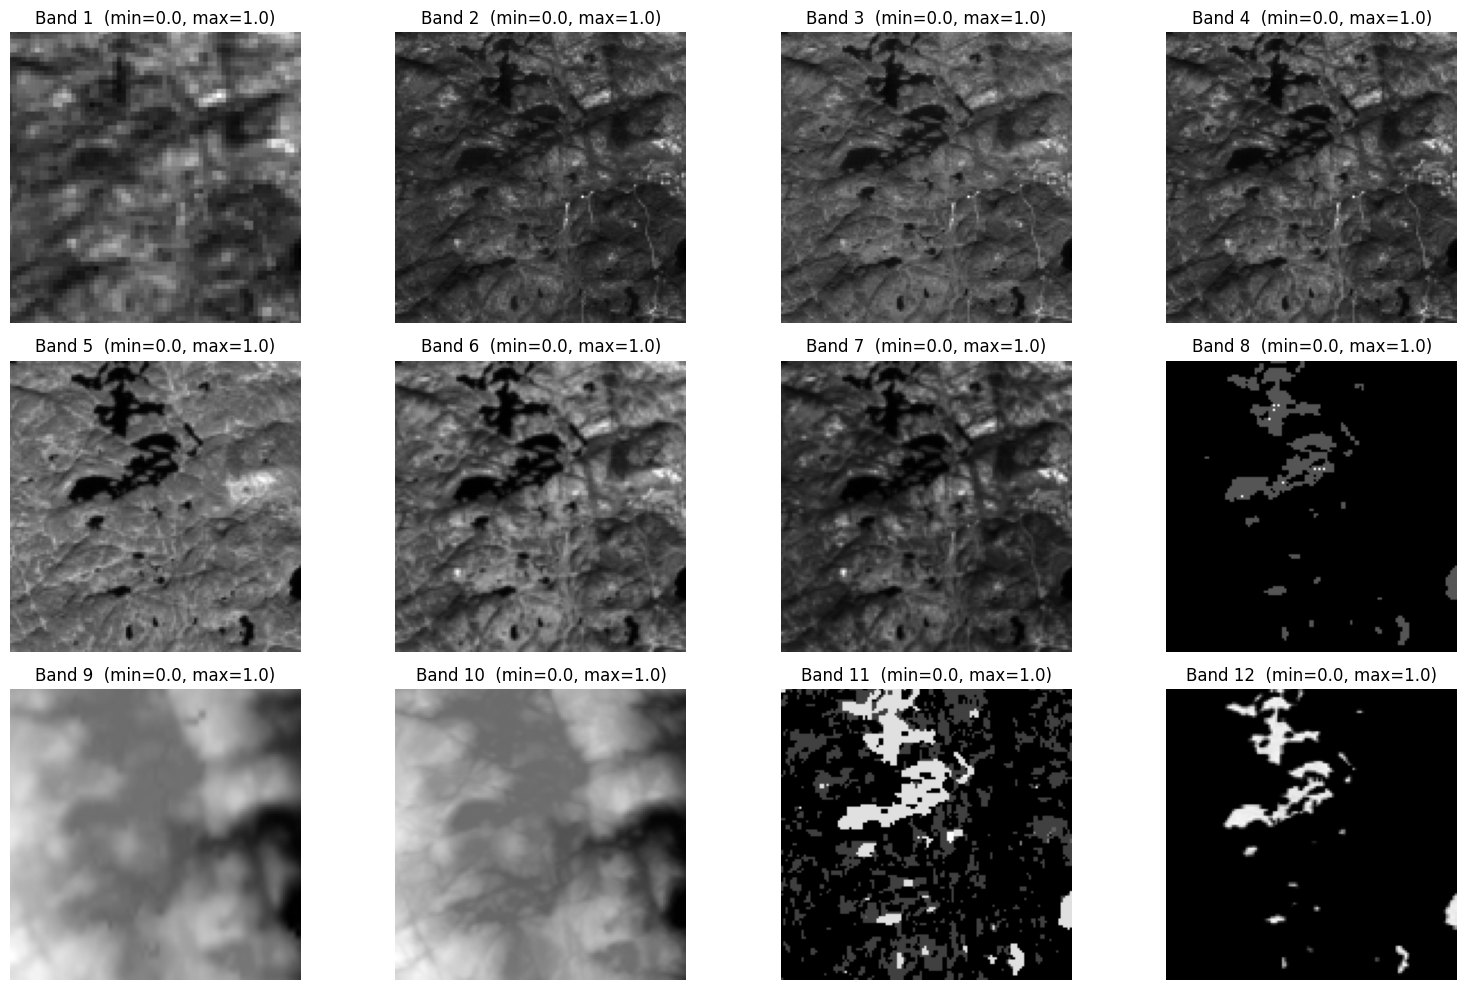

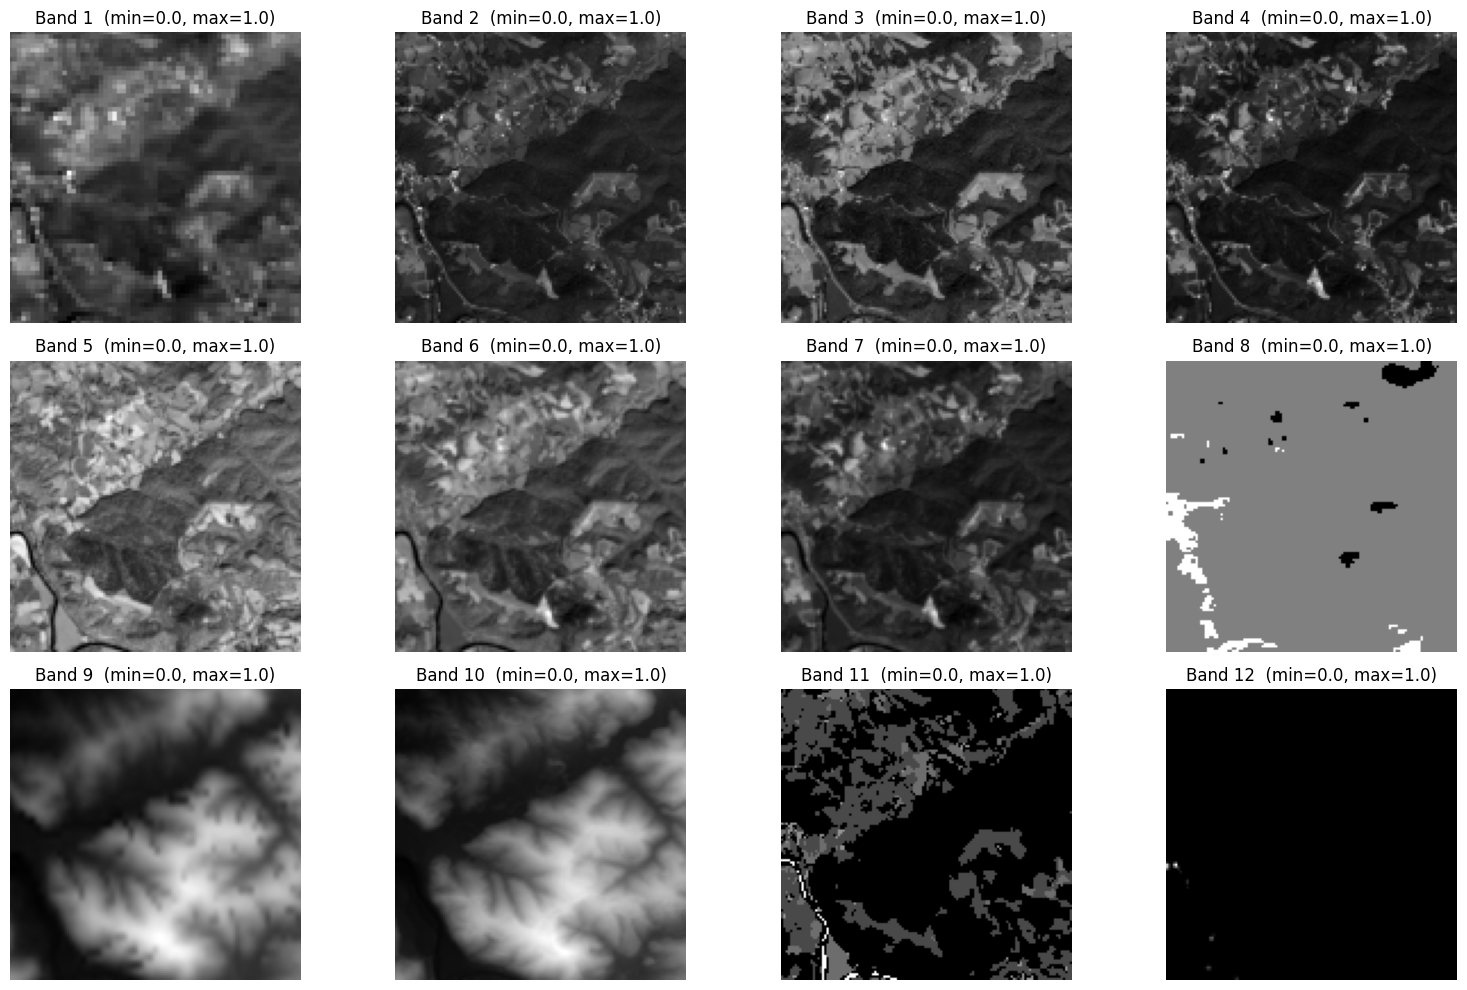

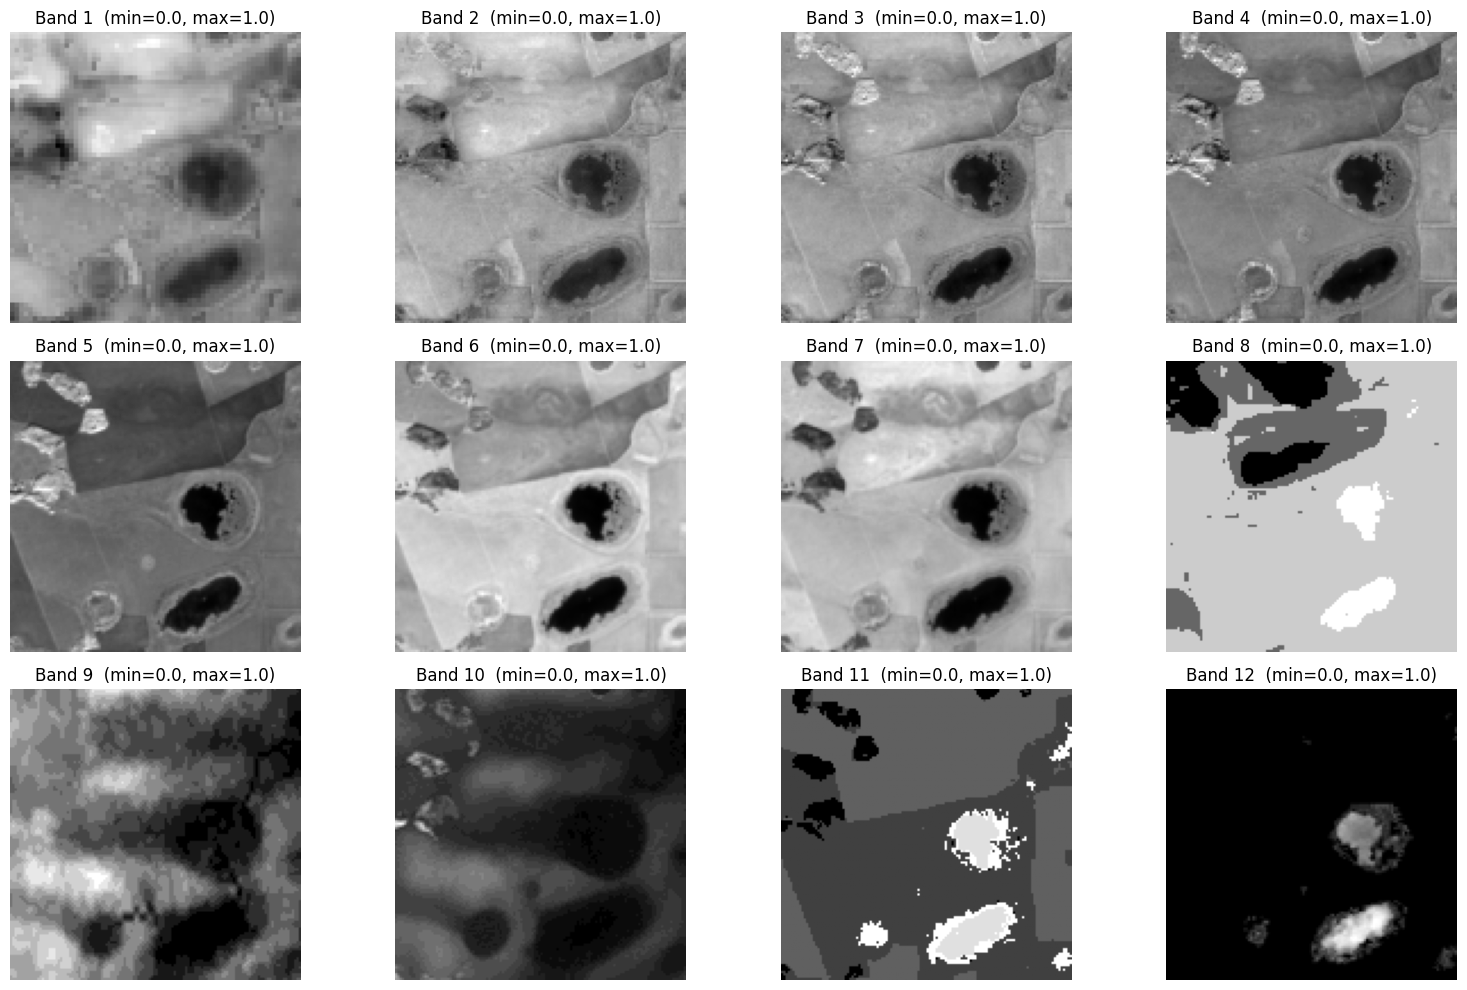

In [125]:
def plot_bands(image):
    norm_img = []
    band_stats = []
    for b in range(12):
        band = image[:, :, b].astype(float)
        band_min = band.min()
        band_max = band.max()
        band_stats.append((band_min, band_max))
        norm_img.append((band - band_min) / (band_max - band_min + 1e-6))
    
    rows, cols = (3, 4)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

    
    for i in range(12):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        ax.imshow(norm_img[i], cmap='gray')
        ax.set_title(f'Band {i+1}  (min={band_stats[i][0]:.1f}, max={band_stats[i][1]:.1f})')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

    return band_stats

stats=[]
for i in range(3):
    stats.append(plot_bands(images[i]))

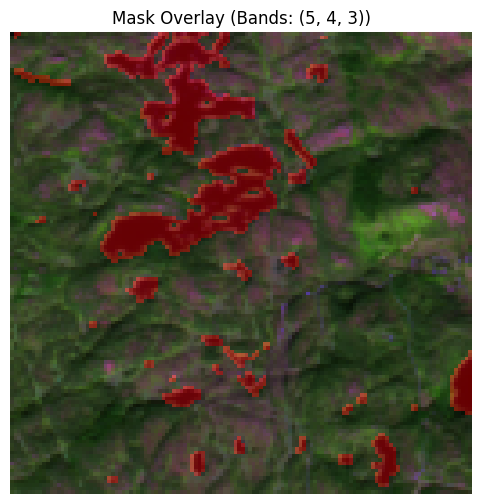

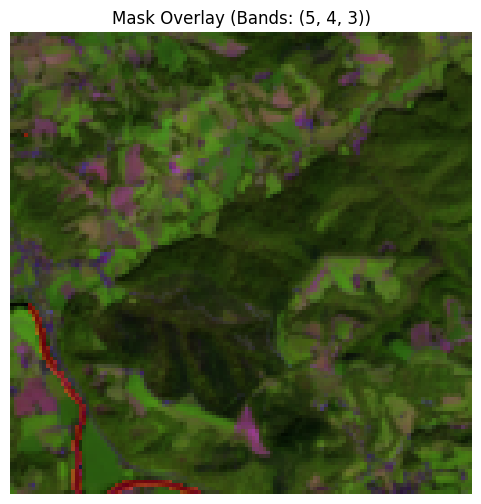

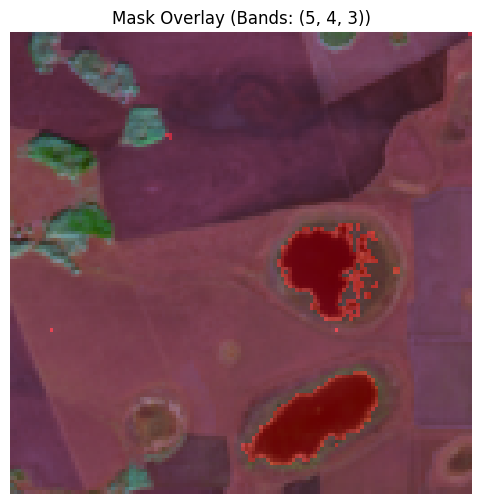

In [127]:
def overlay_mask(image, mask, bands=(3, 2, 1), alpha=0.4):
    rgb = np.stack([image[:, :, b] for b in bands], axis=-1).astype(float)
    for i in range(3):
        bmin, bmax = rgb[..., i].min(), rgb[..., i].max()
        rgb[..., i] = (rgb[..., i] - bmin) / (bmax - bmin + 1e-8)
        
    mask_rgb = np.zeros_like(rgb)
    mask_rgb[..., 0] = mask

    overlay = (1 - alpha) * rgb + alpha * mask_rgb

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f'Mask Overlay (Bands: {bands})')
    plt.axis('off')
    plt.show()

for i in range(3):
    overlay_mask(images[i], masks[i], bands=(5, 4, 3))

In [128]:
selected_bands = [i for i in range(12) if i not in (0, 8, 9)]
images = images[: ,: , : , selected_bands]

In [129]:
images.shape

(306, 128, 128, 9)

In [130]:
def augment(image, mask):
    mask = tf.expand_dims(mask, axis=-1)
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
        
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    
    return image, mask

In [131]:
def preprocess(image, mask):
    mask = tf.expand_dims(mask, axis=-1) 
    return image, mask

In [132]:
split_index = int(0.8 * len(images))  # 80/20 split

train_images, val_images = images[:split_index], images[split_index:]
train_masks, val_masks = masks[:split_index], masks[split_index:]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess,  num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 64
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [133]:
def conv_block(inputs, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [134]:
def build_unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    
    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    return keras.models.Model(inputs, outputs, name="U-Net")

In [135]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * y_true * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss_pos + loss_neg)
    
    return loss

In [136]:
def f1_score(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [137]:
model = build_unet(input_shape=(128, 128, 9))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score,
        tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[0, 1], threshold=0.4)
    ]
)

In [138]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │      5,248 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_63[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 512) │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_65[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 16, 16,    │  2,097,664 │ conv2d_66[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,035,201 (118.39 MB)

 Trainable params: 31,035,201 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

In [140]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5235 - f1_score: 0.2057 - iou: 0.2019 - loss: 0.0934 - precision: 0.2828 - recall: 0.4816 - val_accuracy: 0.7635 - val_f1_score: 0.0000e+00 - val_iou: 0.4869 - val_loss: 0.0456 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 788ms/step - accuracy: 0.7709 - f1_score: 0.1599 - iou: 0.4030 - loss: 0.0452 - precision: 0.7973 - recall: 0.1052 - val_accuracy: 0.8337 - val_f1_score: 0.4590 - val_iou: 0.5024 - val_loss: 0.0382 - val_precision: 0.9961 - val_recall: 0.2982 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step - accuracy: 0.8233 - f1_score: 0.5102 - iou: 0.6150 - loss: 0.0376 - precision: 0.9923 - recall: 0.3426 - val_accuracy: 0.8631 - val_f1_score: 0.5959 - val_iou: 0.6817 - val_loss: 0.0330 - val_precision: 0.9867 - val_recall: 0.4268 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - accuracy: 0.8656 - f

In [145]:
y_true = []
y_pred = []

for images, masks in val_ds:
    preds = model.predict(images)

    preds = (preds > 0.4).astype(np.uint8)
    masks = masks.numpy().astype(np.uint8)

    if preds.shape[-1] == 1:
        preds = np.squeeze(preds, axis=-1)
    if masks.shape[-1] == 1:
        masks = np.squeeze(masks, axis=-1)
    
    y_true.append(masks.flatten())
    y_pred.append(preds.flatten())
    
y_true_flat = np.concatenate(y_true)
y_pred_flat = np.concatenate(y_pred)

precision_val = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall_val = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1_val = f1_score(y_true_flat, y_pred_flat)
iou_val = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

print("\n🔍 Post-Training Evaluation:")
print(f"📌 Precision: {precision_val:.4f}")
print(f"📌 Recall:    {recall_val:.4f}")
print(f"📌 F1 Score:  {f1_val:.4f}")
print(f"📌 IoU:       {iou_val: .4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

🔍 Post-Training Evaluation:
📌 Precision: 0.9374
📌 Recall:    0.6494
📌 F1 Score:  0.7673
📌 IoU:        0.6224


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


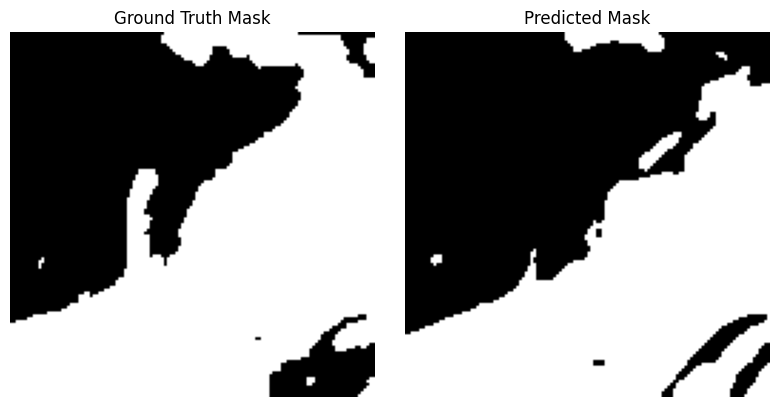

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


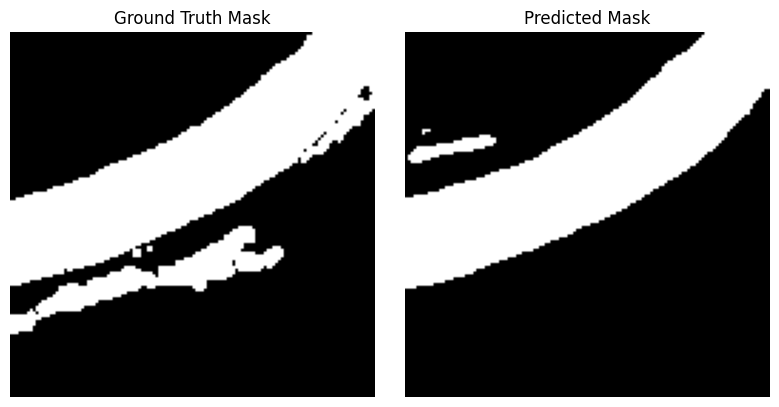

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


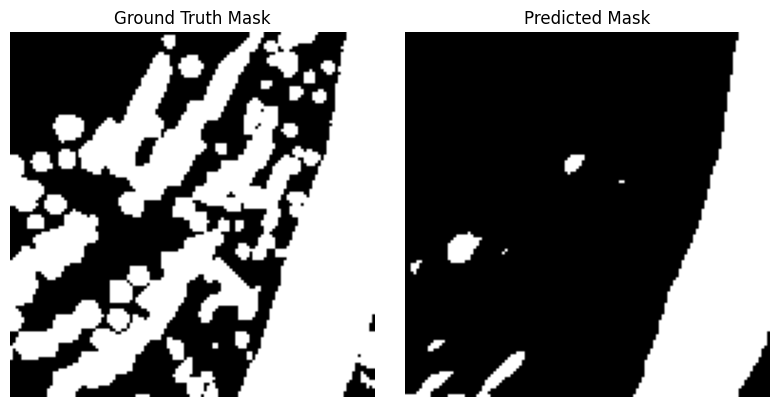

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


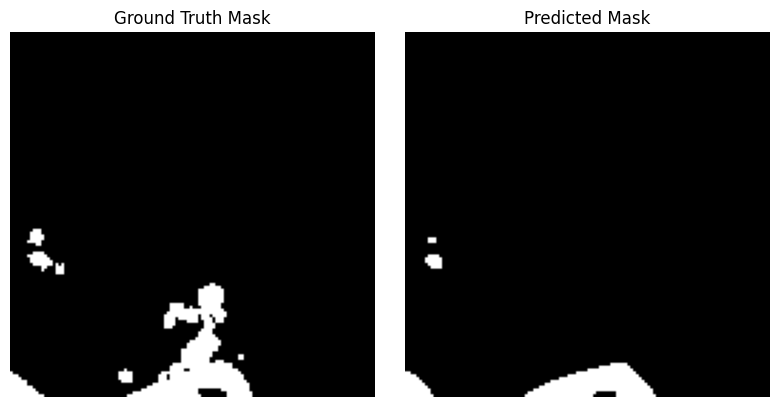

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


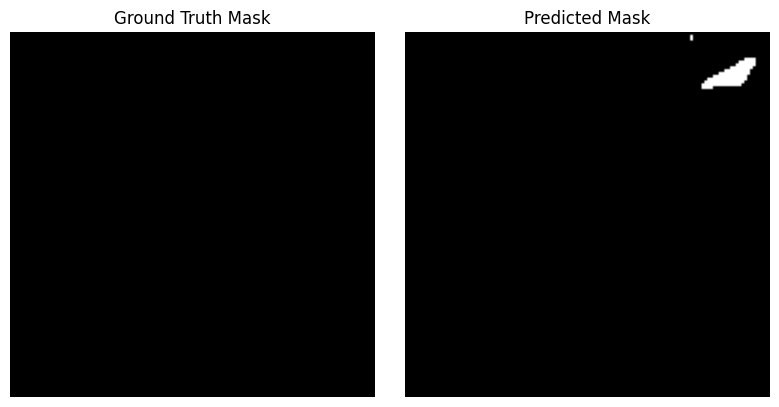

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def display_sample_predictions(val_ds, model, num_samples=5, threshold=0.4):
    # Unbatch the dataset
    val_ds_unbatched = val_ds.unbatch()
    
    for i, (image, true_mask) in enumerate(val_ds_unbatched.take(num_samples)):
        # Expand dims to make it a batch of 1
        input_image = tf.expand_dims(image, axis=0)

        # Predict
        pred_mask = model.predict(input_image)[0]

        # Apply threshold
        pred_mask = (pred_mask > threshold).astype(np.uint8).squeeze()
        true_mask = true_mask.numpy().astype(np.uint8).squeeze()
        image_np = image.numpy()

        # Prepare image for display
        if image_np.shape[-1] == 1:
            image_disp = image_np.squeeze(-1)
            cmap_img = 'gray'
        else:
            image_disp = image_np
            cmap_img = None

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
display_sample_predictions(val_ds, model, num_samples=5)


In [147]:
model.save("myWaterSegmentationModel.h5")